In [46]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

from utils_dp import set_value,get_value,get_prob,get_reward,display_V,get_pi


## 构建4*4方格环境

In [47]:
S = [i for i in range(16)]  # 状态空间
A = ['n', 'e', 's', 'w']  # 行为空间，表示方向，上下左右
ds_actions = {"n": -4, "e": 1, "s": 4, "w": -1}  # 行为对状态的改变,由于采用一维列表，所以上下移动需要+/-4


"""
target:
    方格世界环境动力学
args:
    s 当前状态 0-15
    a 行为    n,e,s,w
returns:
    s_prime 后续状态
    reward 奖励值
    is_end 是否进入终止状态 
"""


def dynamic(s, a):
    s_prime = s
    #当前状态下无法移动的行为，此时状态不变
    if (s % 4 == 0 and a == "w")\
        or (s < 4 and a == "n") \
        or ((s + 1) % 4 == 0 and a == "e")\
        or (s > 11 and a == "s")\
        or s in [0, 15]:
        pass
    else:  # 可以移动的行为
        ds = ds_actions[a]
        s_prime = s + ds
    reward = 0 if s in [0, 15] else -1
    is_end = True if s in [0, 15] else False
    return s_prime, reward, is_end


"""
target:
    状态转移概率
args:
    s 当前状态 0-15
    a 行为    n,e,s,w
    s1 准备到达的后续状态
returns:
    True / False
"""


def P(s, a, s1):
    s_prime, _, _, = dynamic(s, a)
    return s1 == s_prime


"""
target:
    奖励函数
args:
    s 当前状态 0-15
    a 行为    n,e,s,w
returns:
    reward 奖励值
"""

def R(s, a):
    _, reward, _ = dynamic(s, a)
    return reward


gamma = 1.0
MDP = S,A,R,P,gamma

### 采用均一随机策略和贪心策略

In [48]:
"""
target:
args:
return:
"""
"""
target:
    求均一随即策略下状态转移概率
args:
    MDP 马尔科夫链
    V 价值函数
    s 状态
    a 动作行为
return:
    状态转移概率
"""


def uniform_random_pi(MDP = None, V = None, s = None, a = None):
    _,A,_,_,_ = MDP
    n = len(A)
    return 0 if n == 0 else 1.0/n


"""
target:
    求贪心策略下状态转移概率,当有多个状态价值一样的状态时，随机选择一个能到达最大状态价值的行为
args:
    MDP 马尔科夫链
    V 价值函数
    s 状态
    a 动作行为
return:
    状态转移概率
"""


def greedy_pi(MDP, V, s, a):
    S, A, P, R, gamma = MDP
    max_v, a_max_v = -float('inf'), []
    # 统计后续状态的最大价值以及到达到达该状态的行为(可能不止一个)
    for a_opt in A:
        s_prime, reward, _ = dynamic(s, a_opt)
        v_s_prime = get_value(V, s_prime)
        if v_s_prime > max_v:
            max_v = v_s_prime
            a_max_v = [a_opt]
        elif v_s_prime == max_v:
            a_max_v.append(a_opt)
    n = len(a_max_v)
    if n == 0:
        return 0.0
    return 1.0/n if a in a_max_v else 0.0


In [49]:
'''
target: 
    计算行为价值函数
args:
    MDP   马尔可夫链
    V   价值函数
    s   状态
    a   行为
return：
    qsa 行为价值
'''


def compute_q(MDP, V, s, a):
    S, A, R, P, gamma = MDP
    qsa = 0
    for s_prime in S:
        qsa += get_prob(P, s, a, s_prime) * get_value(V, s_prime)
    qsa = get_reward(R, s, a) + gamma * qsa
    return qsa


'''
target: 
    计算状态价值函数
args:
    MDP   马尔可夫链
    V   价值函数
    s   状态
    Pi   策略
return：
    vsa 行为价值
'''


def compute_v(MDP, V, Pi, s):
    S, A, R, P, gamma = MDP
    vs = 0
    for a in A:
        vs += get_pi(Pi, s, a, MDP, V) * compute_q(MDP, V, s, a)
    return vs


'''
target: 
    给定一个MDP和一个策略，每一次迭代都有更新该策略下的价值函数V
args:
    MDP   马尔可夫链
    V   价值函数
    Pi   策略
return：
    V   更新后的价值函数
'''


def update_V(MDP, V, Pi):
    S, _, _, _, _ = MDP
    V_prime = V.copy()
    for s in S:
        set_value(V_prime, s, compute_v(MDP, V_prime, Pi, s))
    return V_prime


'''
target: 
    策略评估：给定一个MDP和一个策略，n次迭代后的价值函数V
args:
    MDP   马尔可夫链
    V   初始价值
    Pi   策略
    n   迭代次数
return：
    V   更新后的价值函数
'''


def policy_evaluate(MDP, V, Pi, n):
    for i in range(n):
        V = update_V(MDP, V, Pi)
    return V


'''
target: 
    策略迭代：给定一个MDP,使用贪心策略，n次迭代后的价值函数V
args:
    MDP   马尔可夫链
    V   初始价值
    Pi   策略
    n   每次迭代次数
return：
    V   更新后的价值函数
'''

def policy_iterate(MDP, V, Pi, n):
    #Pi = greedy_pi
    V = policy_evaluate(MDP, V, Pi, n)
    return V


'''
target: 
    价值迭代：给定一个MDP,基于bellman最优方程求解当前状态的价值函数
args:
    MDP   马尔可夫链
    V   初始价值
    s   当前状态
return：
    vs   价值迭代更新后的价值函数
'''


def compute_v_from_max_q(MDP, V, s):
    S, A, R, P, gamma = MDP
    vs = -float('inf')
    for a in A:
        qsa = compute_q(MDP, V, s, a)
        if qsa >= vs:
            vs = qsa
    return vs


'''
target: 
    给定一个MDP，每一次迭代都有更新该策略下的价值函数V
args:
    MDP   马尔可夫链
    V   价值函数
return：
    V   更新后的价值函数
'''


def update_V_without_pi(MDP, V):
    S, _, _, _, _ = MDP
    V_prime = V.copy()
    for s in S:
        set_value(V_prime, s, compute_v_from_max_q(MDP, V_prime, s))
    return V_prime


'''
target: 
    价值迭代：n次迭代后的价值函数V
args:
    MDP   马尔可夫链
    V   初始价值
    n   迭代次数
return：
    V   更新后的价值函数
'''


def value_iterate(MDP, V, n):
    for i in range(n):
        V = update_V_without_pi(MDP, V)
    return V

### 迭代策略评估

In [50]:
#初始状态价值
V = [0 for i in range(16)]

#采用均一随机策进行策略评估，迭代100次
V_pi = policy_evaluate(MDP,V,uniform_random_pi, 100)
display_V(V_pi)
print()
#采用贪心策略进行策略评估，迭代100次
V_pi = policy_evaluate(MDP,V,greedy_pi, 100)
display_V(V_pi)

  0.00 -14.00 -20.00 -22.00 
-14.00 -18.00 -20.00 -20.00 
-20.00 -20.00 -18.00 -14.00 
-22.00 -20.00 -14.00   0.00 


  0.00  -1.00  -2.00  -3.00 
 -1.00  -2.00  -3.00  -2.00 
 -2.00  -3.00  -2.00  -1.00 
 -3.00  -2.00  -1.00   0.00 



### 策略迭代

In [51]:
V = [0 for i in range(16)]
V_pi = policy_iterate(MDP,V,greedy_pi, 100)
display_V(V_pi)


  0.00  -1.00  -2.00  -3.00 
 -1.00  -2.00  -3.00  -2.00 
 -2.00  -3.00  -2.00  -1.00 
 -3.00  -2.00  -1.00   0.00 



### 价值迭代

In [52]:
# 价值迭代,迭代4次
#V = [0 for i in range(16)]
V_star = value_iterate(MDP, V, 4)
display_V(V_star)

  0.00  -1.00  -2.00  -3.00 
 -1.00  -2.00  -3.00  -2.00 
 -2.00  -3.00  -2.00  -1.00 
 -3.00  -2.00  -1.00   0.00 



可以看到采用策略迭代和价值迭代在经过数次迭代后最终获得的价值函数相同，因为都采用了贪心的思路，但是具体解决方式不同。
ps：在计算过程中，如果位于边界的状态某个方向无法继续移动，认为下一个状态仍然为原状态（$v_s'）

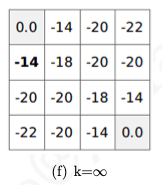

In [55]:
#求最佳价值函数对应的最佳策略，greedy_policy与之前的greedy_pi基本相同
# 区别在greedy_policy返回的是获得最佳价值函数的动作，greedy_pi返回的是贪心策略下的状态转移概率

def greedy_policy(MDP, V, s):
    S, A, R, P, gamma = MDP
    max_v, a_max_v = -float('inf'), ""
    # 统计后续状态的最大价值以及到达到达该状态的行为(可能不止一个)
    for a_opt in A:
        s_prime, reward, _ = dynamic(s, a_opt)
        v_s_prime = get_value(V, s_prime)
        if v_s_prime > max_v:
            max_v = v_s_prime
            a_max_v = a_opt
        elif v_s_prime == max_v:
            a_max_v += a_opt

    return str(a_max_v)



def display_policy(policy, MDP, V):
    S, A, R, P, gamma = MDP
    for i in range(16):
        print('{0:^6}'.format(policy(MDP, V, S[i])), end=" ")
        if (i+1)%4 == 0:
            print(" ")
    print()
    

In [56]:
display_policy(greedy_policy, MDP, V_star)

['n', 'e', 's', 'w'] ['w']  ['w']  ['s', 'w']  
['n']  ['n', 'w'] ['n', 'e', 's', 'w'] ['s']   
['n']  ['n', 'e', 's', 'w'] ['e', 's'] ['s']   
['n', 'e'] ['e']  ['e']  ['n', 'e', 's', 'w']  

